### SI figure notebook for comparing bulk RNA count correlations between MERFISH replicates

In [63]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import numpy as np
import anndata
import scanpy
import string
import seaborn as sns
import h5py
import math
%matplotlib inline

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,12])
    plt.rc('svg', fonttype='none')

# To do: 

In [106]:
# Load data

dataPathRaw = '../../../MERlin_Analysis'
dataPath = '../../../MERlin_Analysis/ProcessedResults/BulkCounts'

experimentNamesPM1_liver1 = ['Msliver_Cellboundary_PM1_12032020',
                   'Msliver_Cellboundary_PM1_12182020',
                   'Msliver_Cellboundary_PM1_12212020']

experimentNamesVZG116_liver1 = ['Msliver_VZG116_021121',
                   'Msliver_VZG116_021221',
                   'Msliver_VZG116_021621',
                   'Msliver_VZG116_021721']

experimentNamesVZG116_liver2 = ['Msliver_CellBoundary_VZG116_031221',
                   'Msliver_CellBoundary_VZG116_031521',
                   'Msliver_CellBoundary_VZG116_031921',
                   'Msliver_CellBoundary_VZG116_041521']

experimentNamesVZG116_kidney1 = ['Mskidney_CellBoundary_VZG116_022221',
                   'Mskidney_CellBoundary_VZG116_022321'] 
    #Note that the 3/16/21 kidney dataset is omitted due to overnight reboot compromising quality
    
experimentNamesVZG116_pancreas1 = ['MsPancreas_CellBoundary_VZG116_030121',
                   'MsPancreas_CellBoundary_VZG116_030421',
                   'MsPancreas_CellBoundary_VZG116_041221',
                   'MsPancreas_CellBoundary_VZG116_041321',
                   'MsPancreas_CellBoundary_VZG116_041421']

experimentNames = {'PM1_liver1': experimentNamesPM1_liver1,
                  'VZG116_liver1': experimentNamesVZG116_liver1,
                  'VZG116_liver2': experimentNamesVZG116_liver2,
                  'VZG116_kidney1': experimentNamesVZG116_kidney1,
                  'VZG116_pancreas1': experimentNamesVZG116_pancreas1}

# Load gene count matrices and barcodes
geneCounts = {}
detectedTranscripts = {}
tissues = list(experimentNames.keys()) #List of tissues

for i in range(len(tissues)):
    geneCounts[tissues[i]] = [pd.read_csv(os.path.join(
        dataPath, experimentNames[tissues[i]][j]) + '_BulkRNACounts.csv') 
        for j in range(len(experimentNames[tissues[i]]))]
    detectedTranscripts[tissues[i]] = [pd.read_csv(os.path.join(
        dataPathRaw, experimentNames[tissues[i]][j]) + '/ExportBarcodes/barcodes.csv') 
        for j in range(len(experimentNames[tissues[i]]))]

print('Gene counts matrices and barcodes loaded.')

Gene counts matrices and barcodes loaded.


In [114]:
len(pd.unique(detectedTranscripts[tissues[0]][0]['fov']))

449

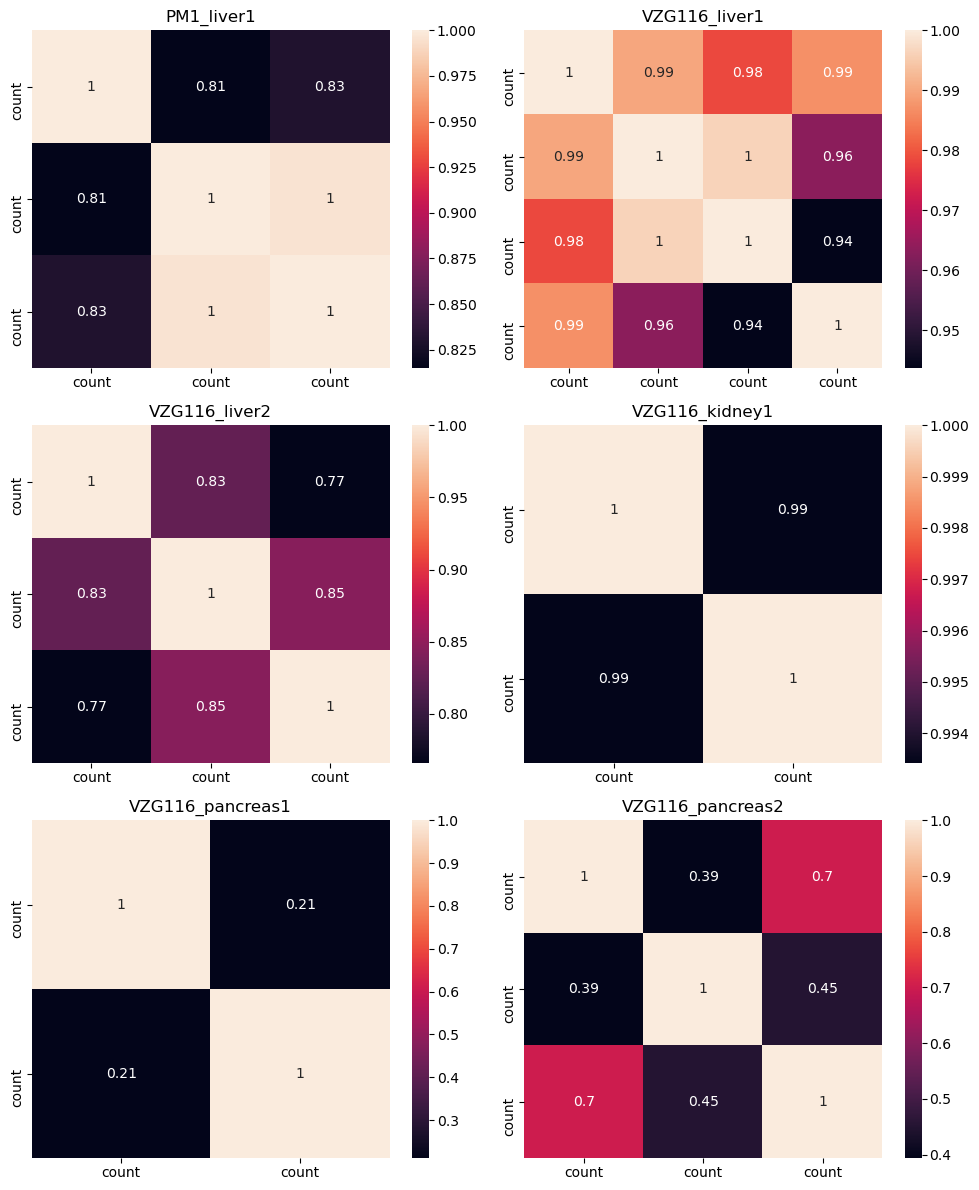

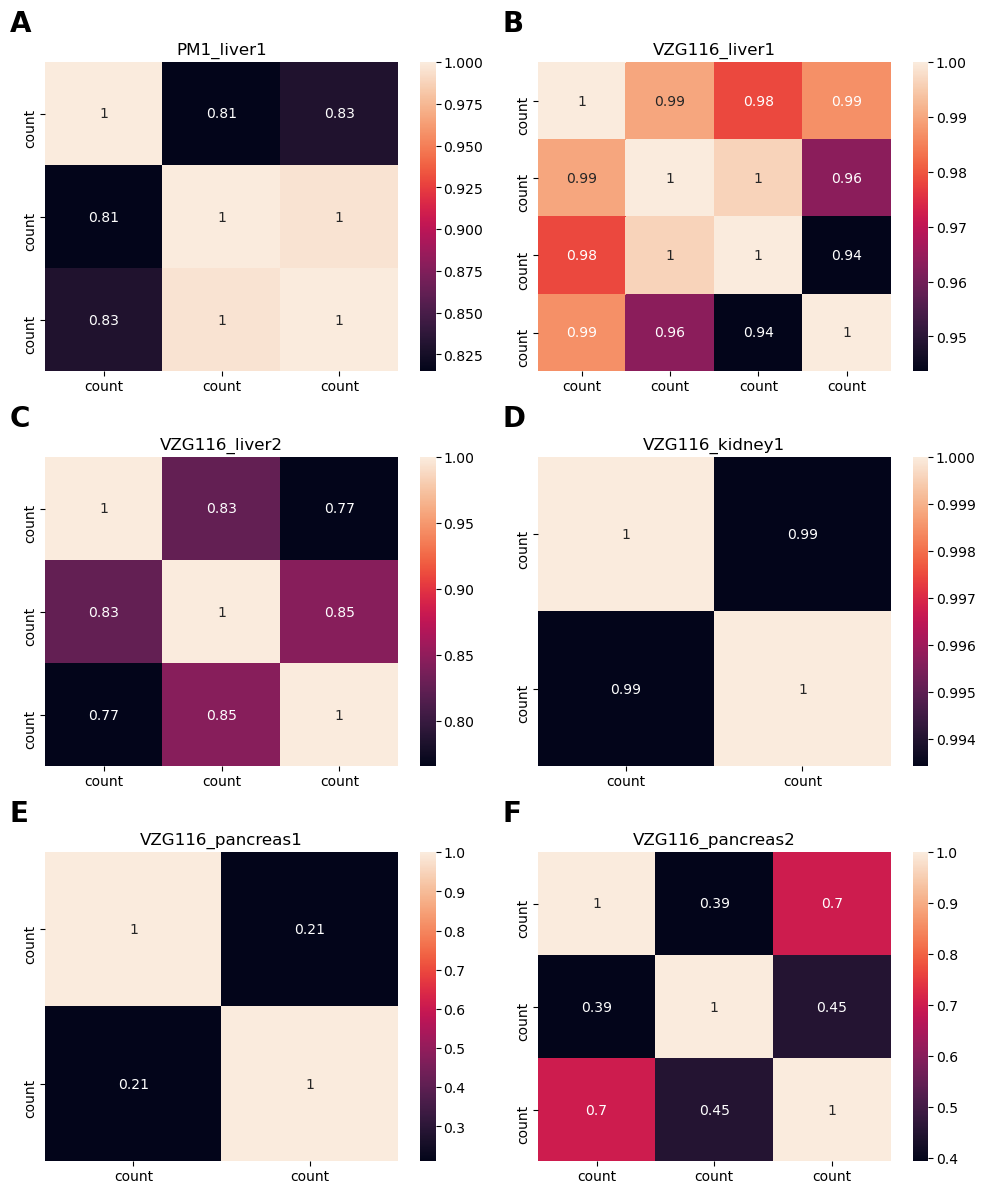

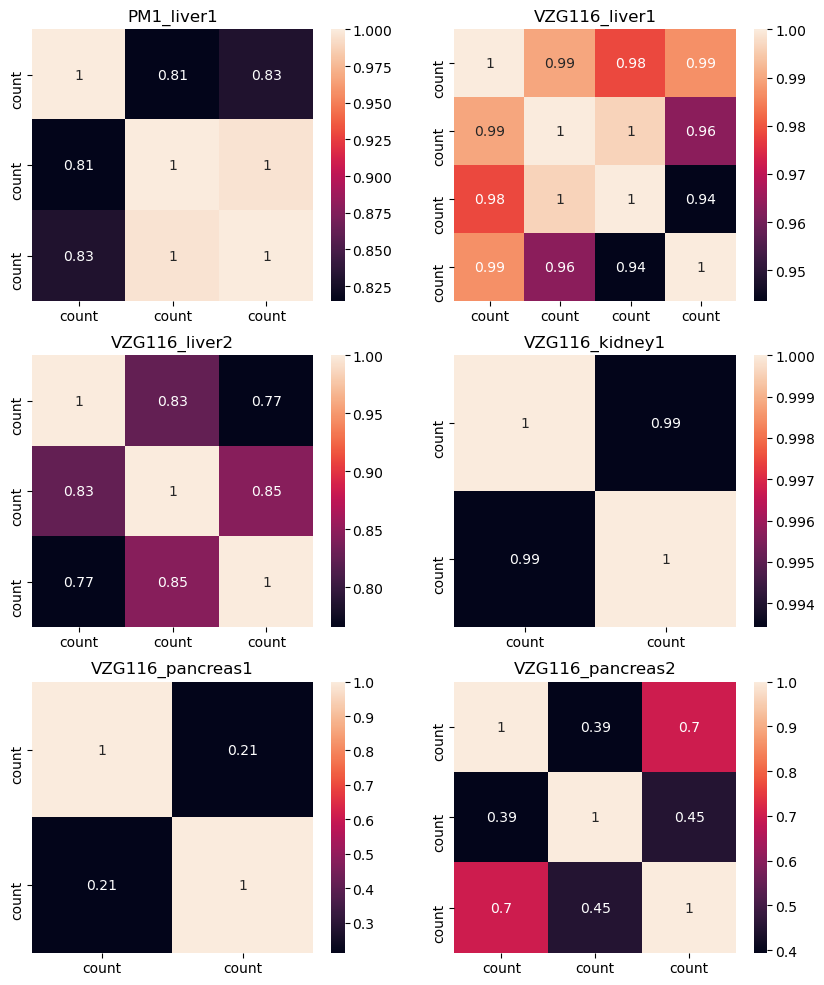

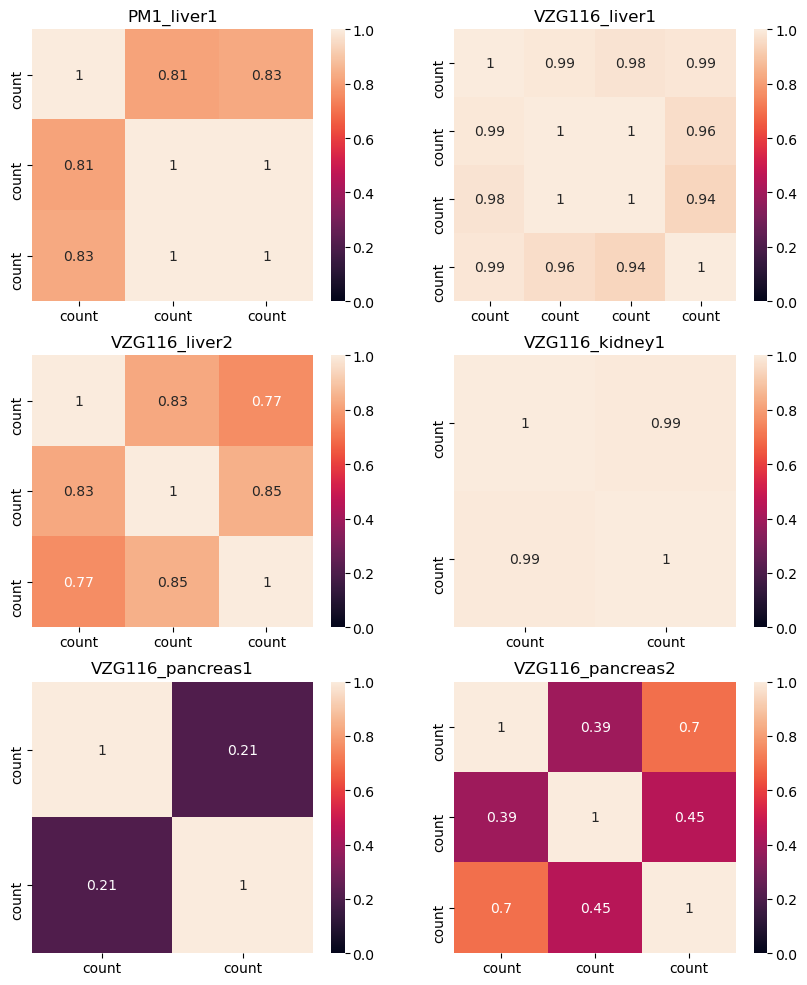

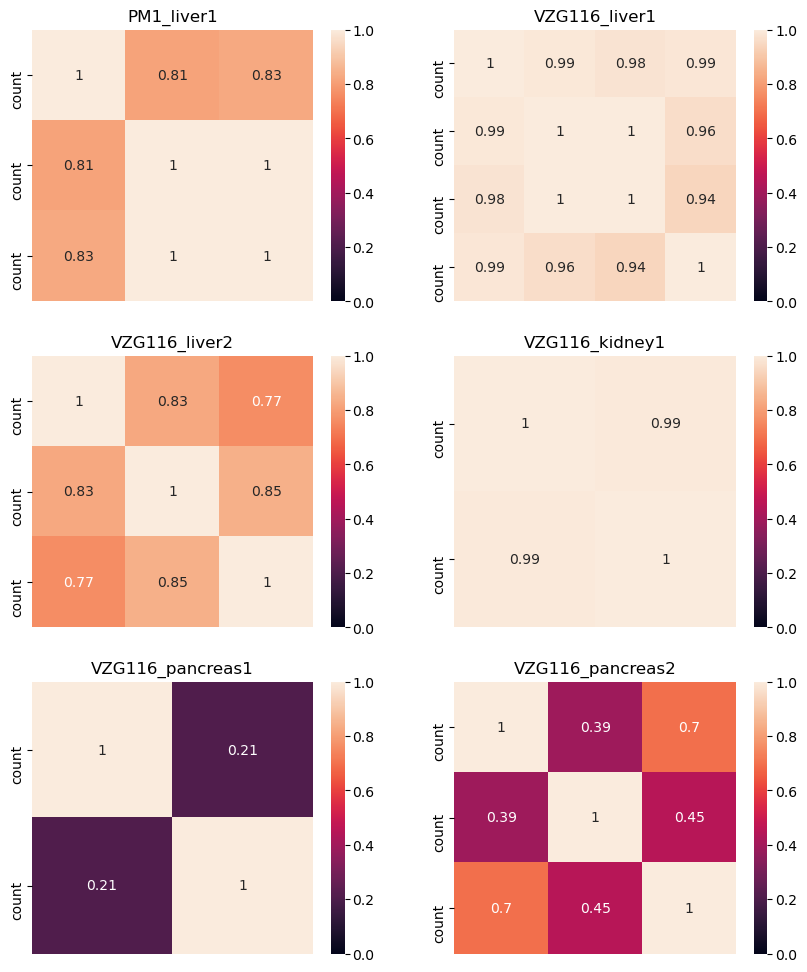

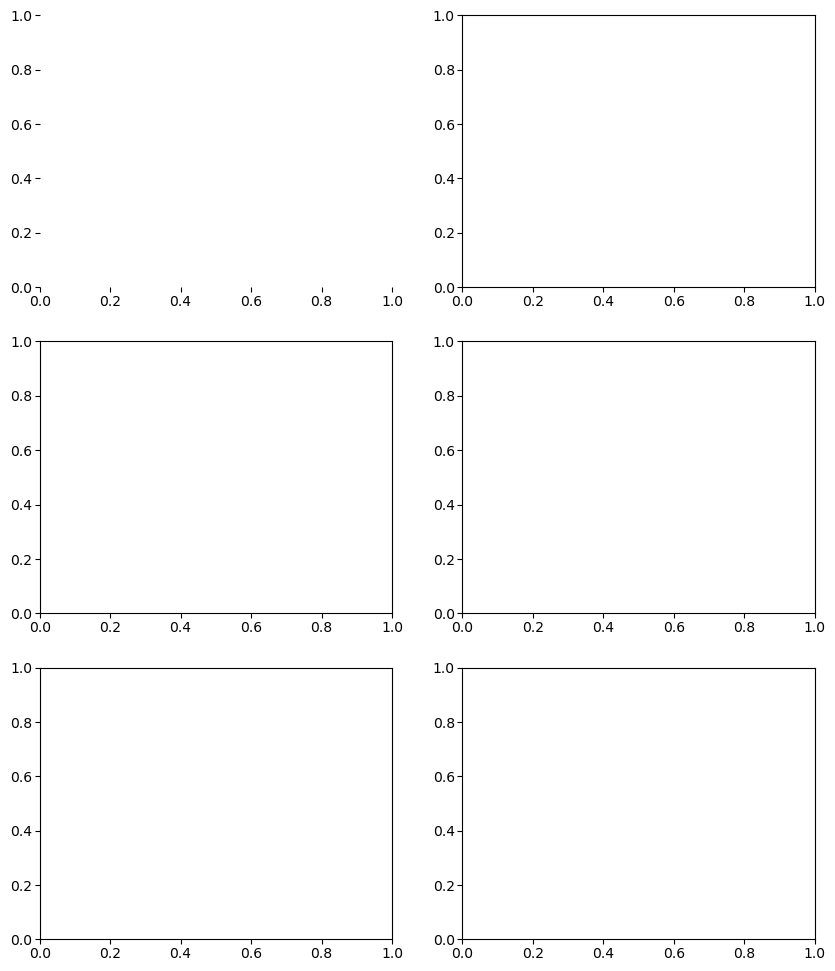

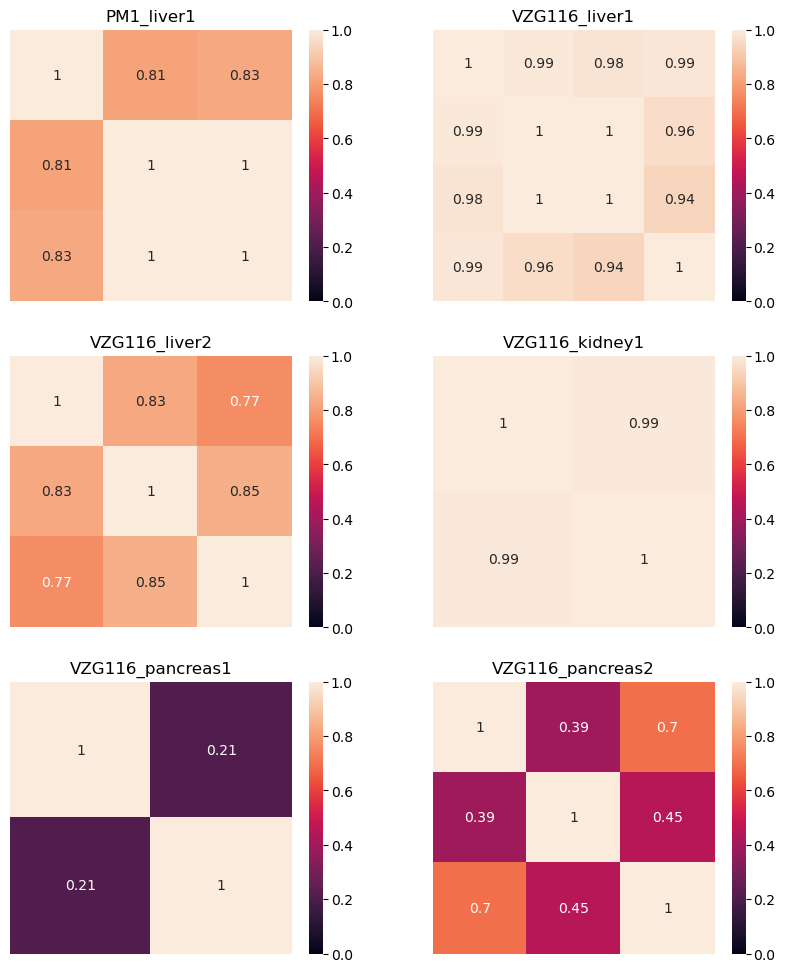

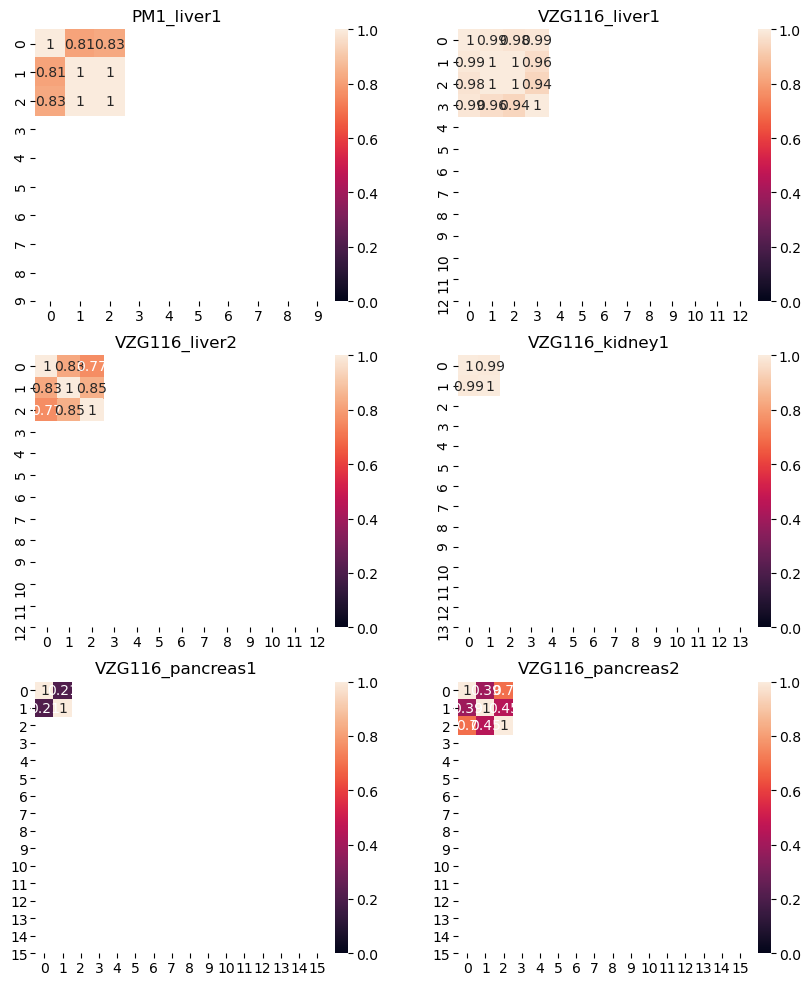

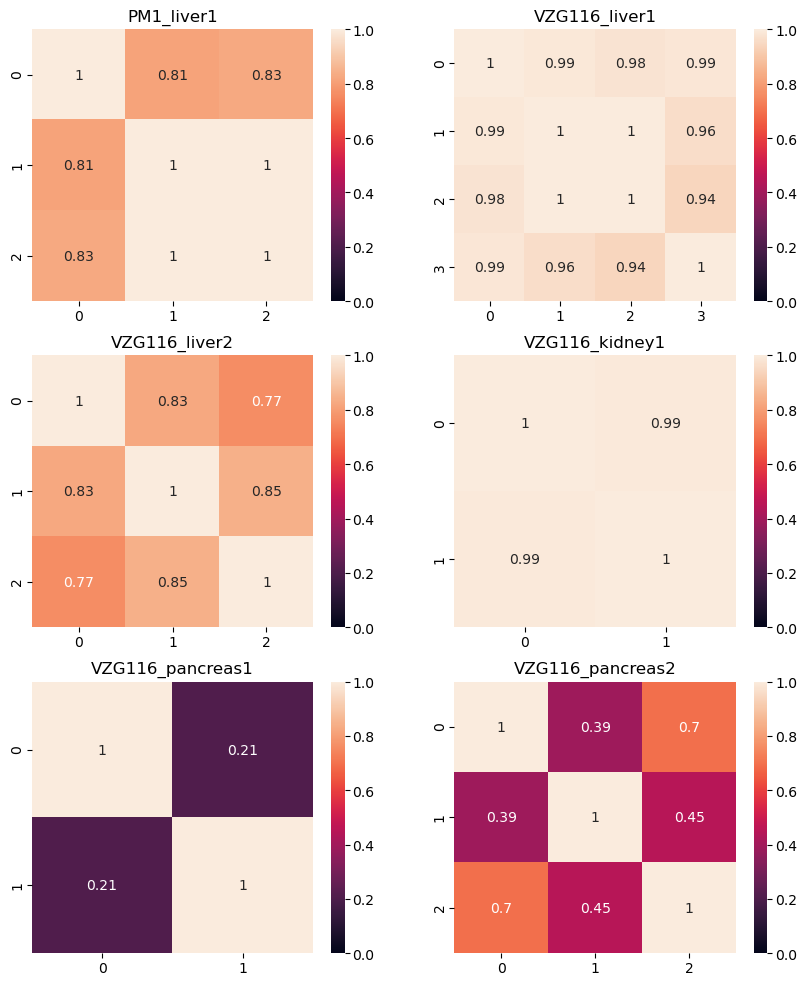

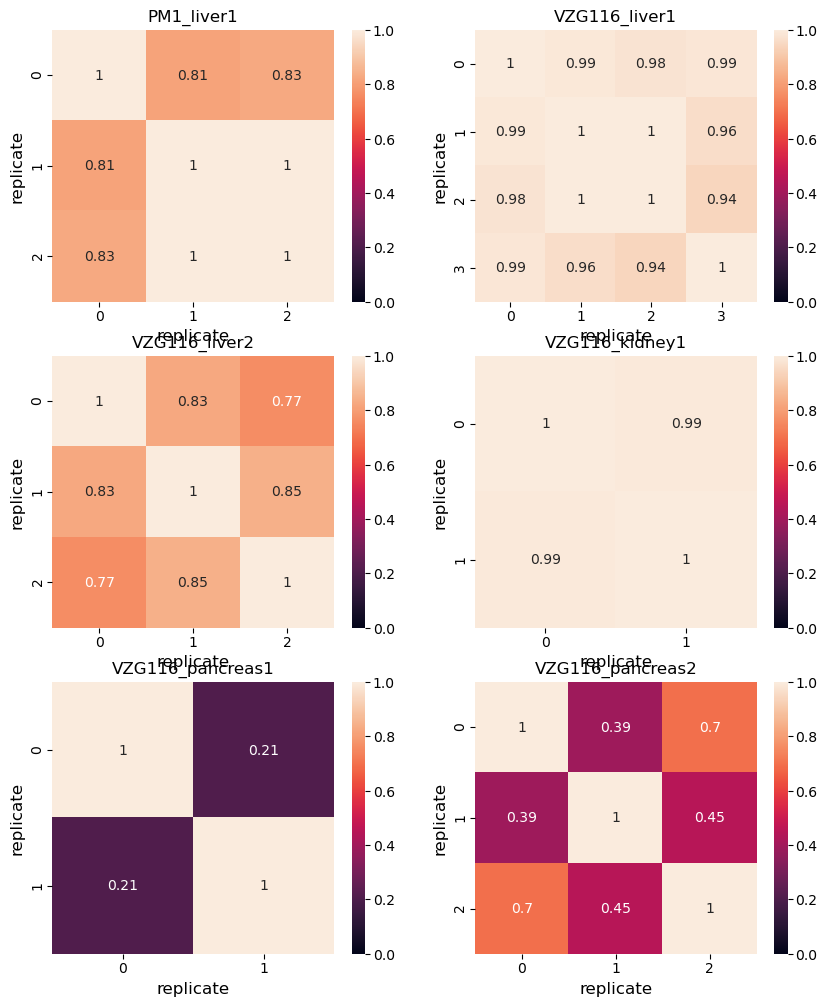

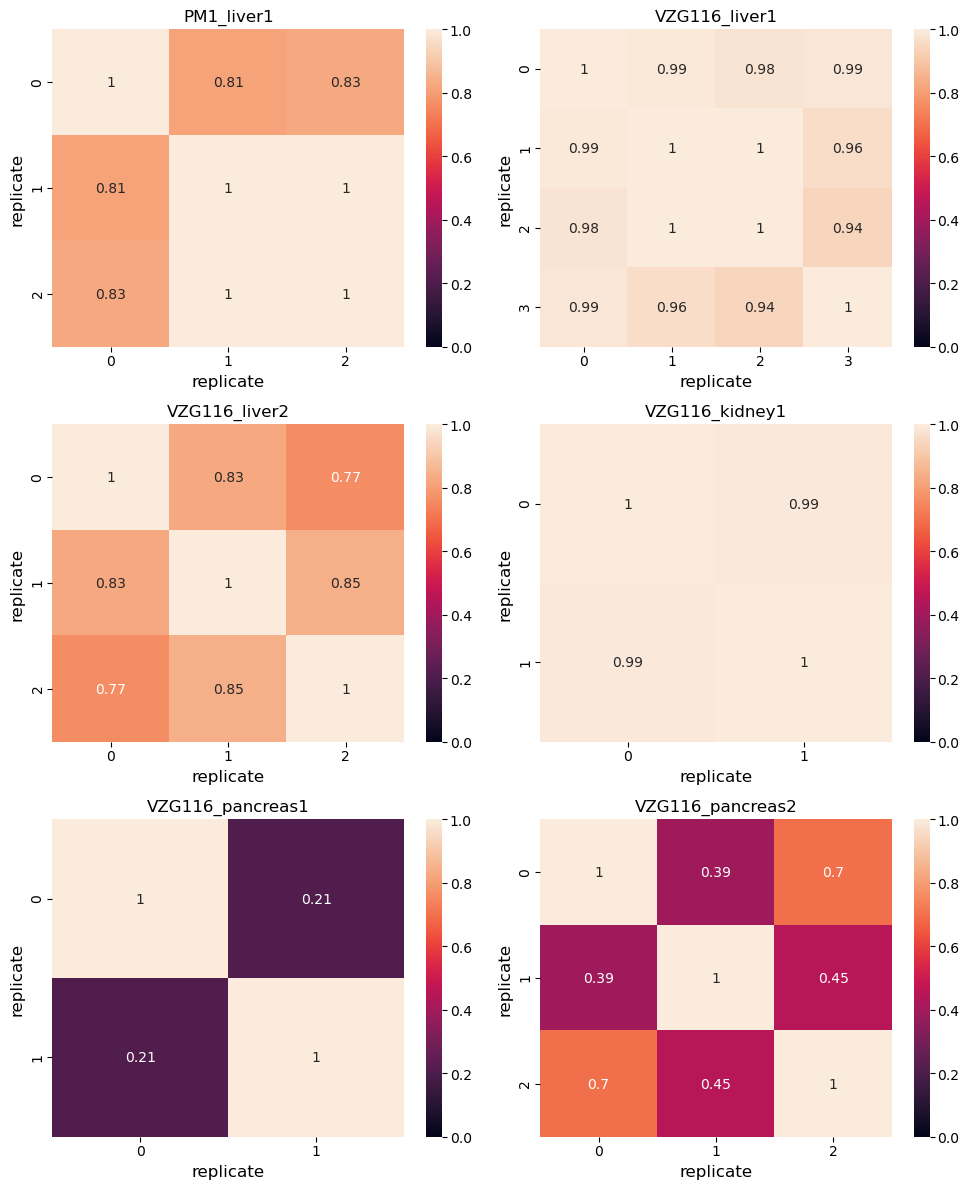

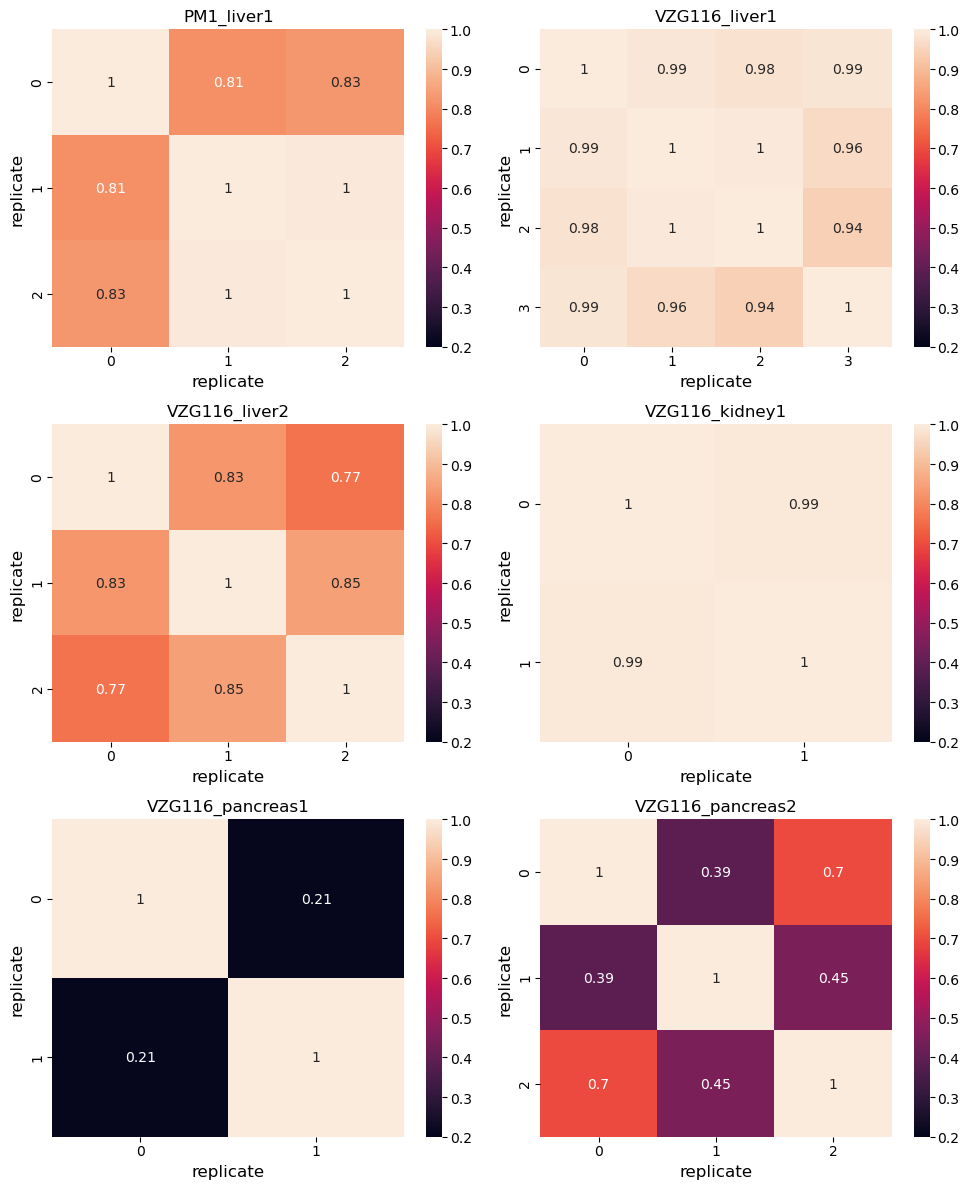

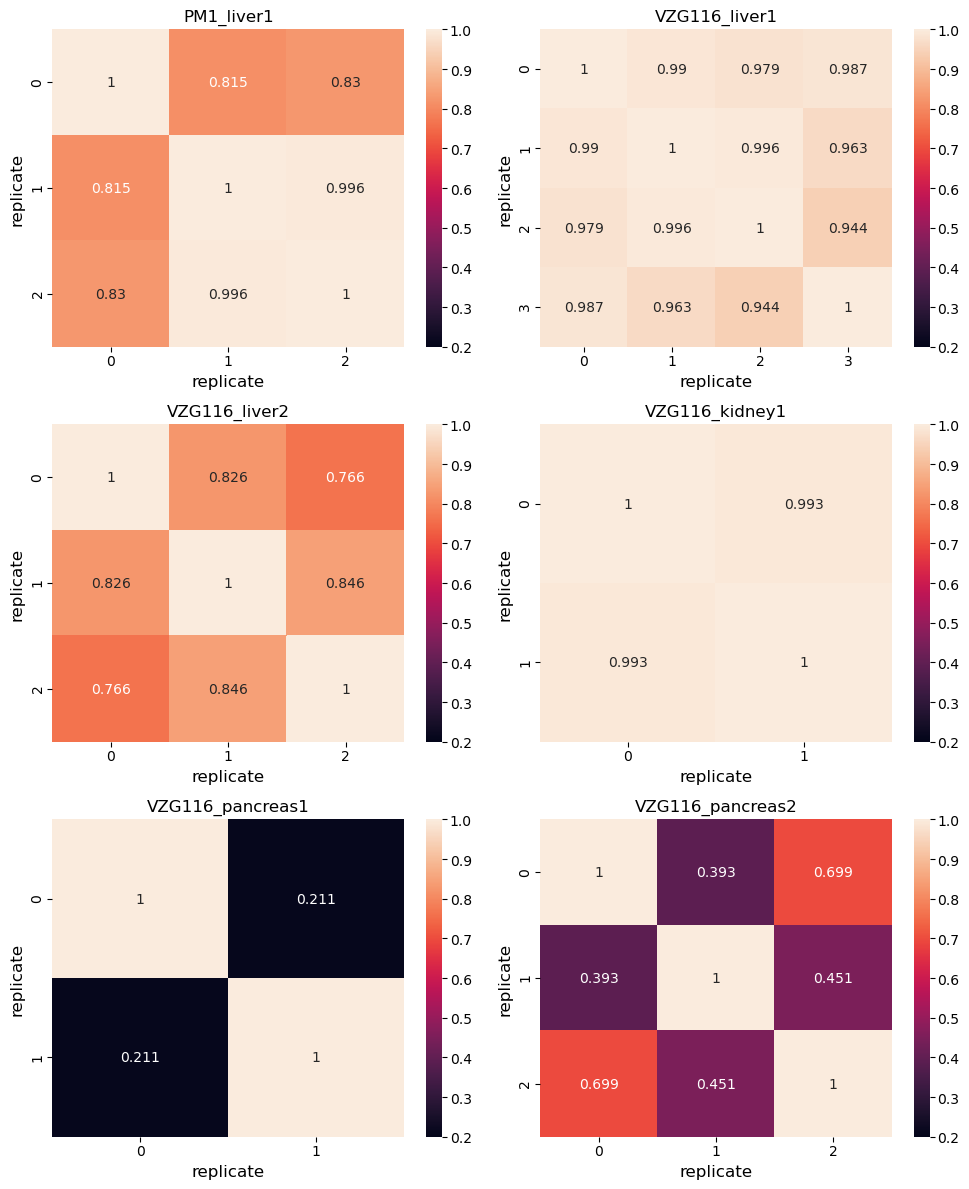

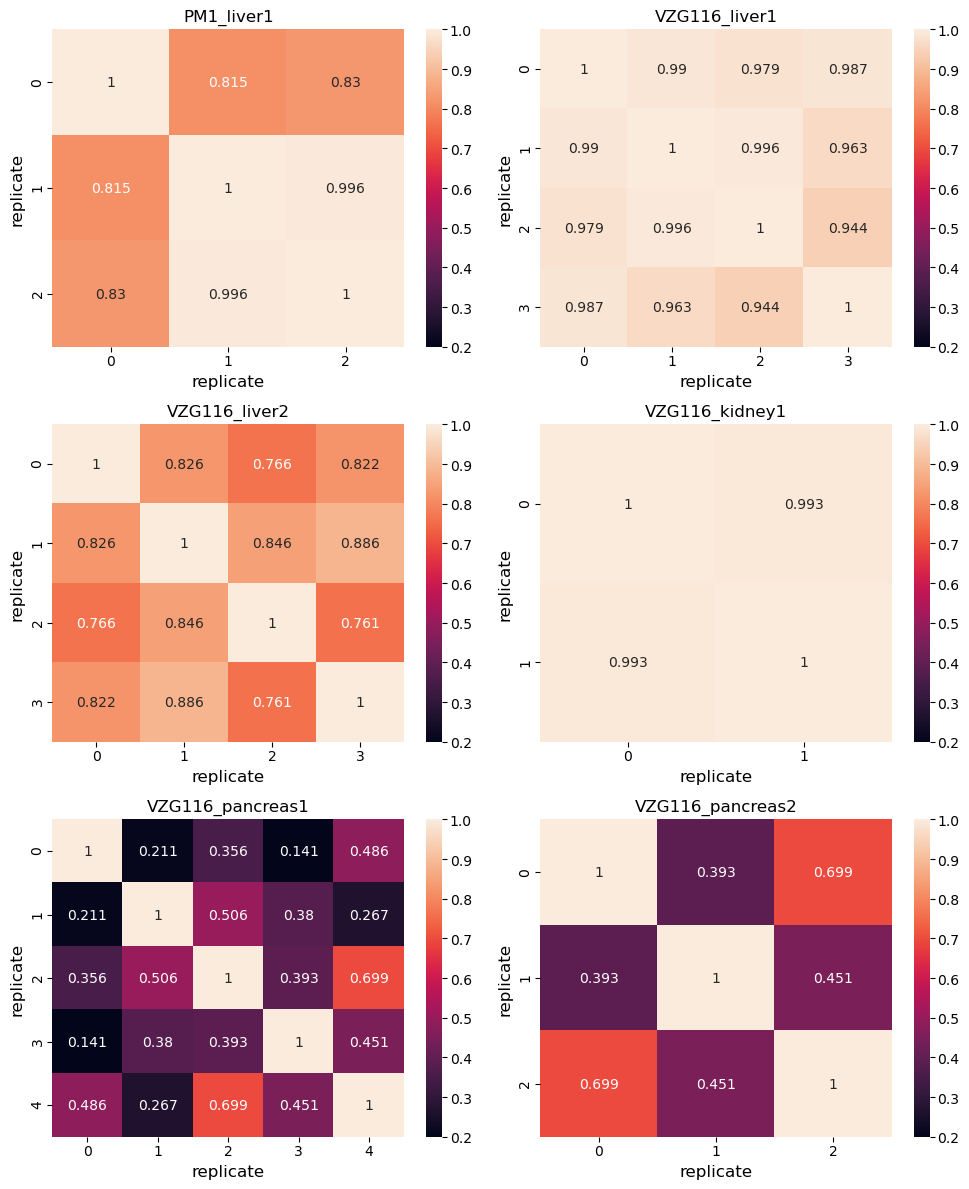

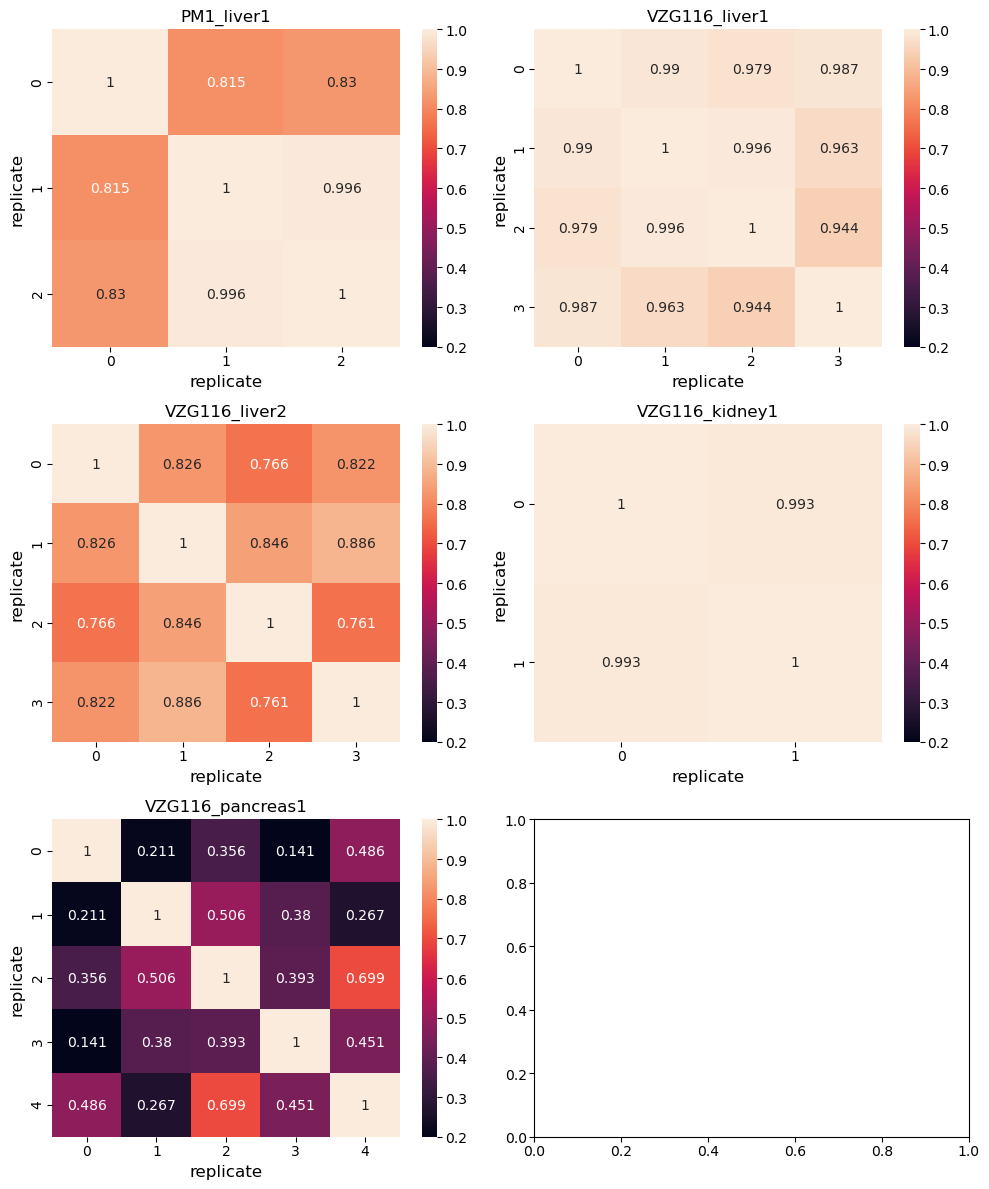

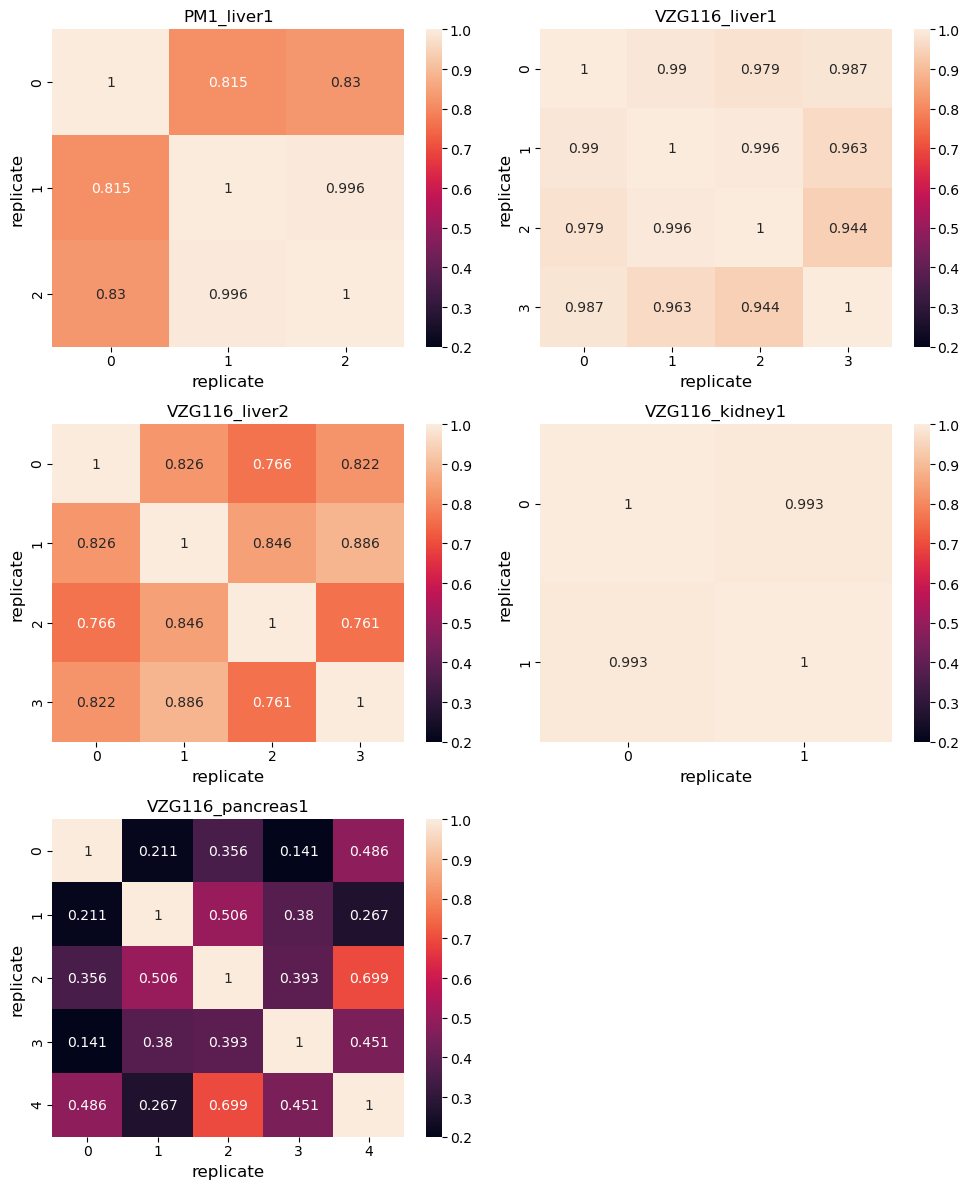

<Figure size 1000x1200 with 0 Axes>

<Figure size 1000x1200 with 0 Axes>

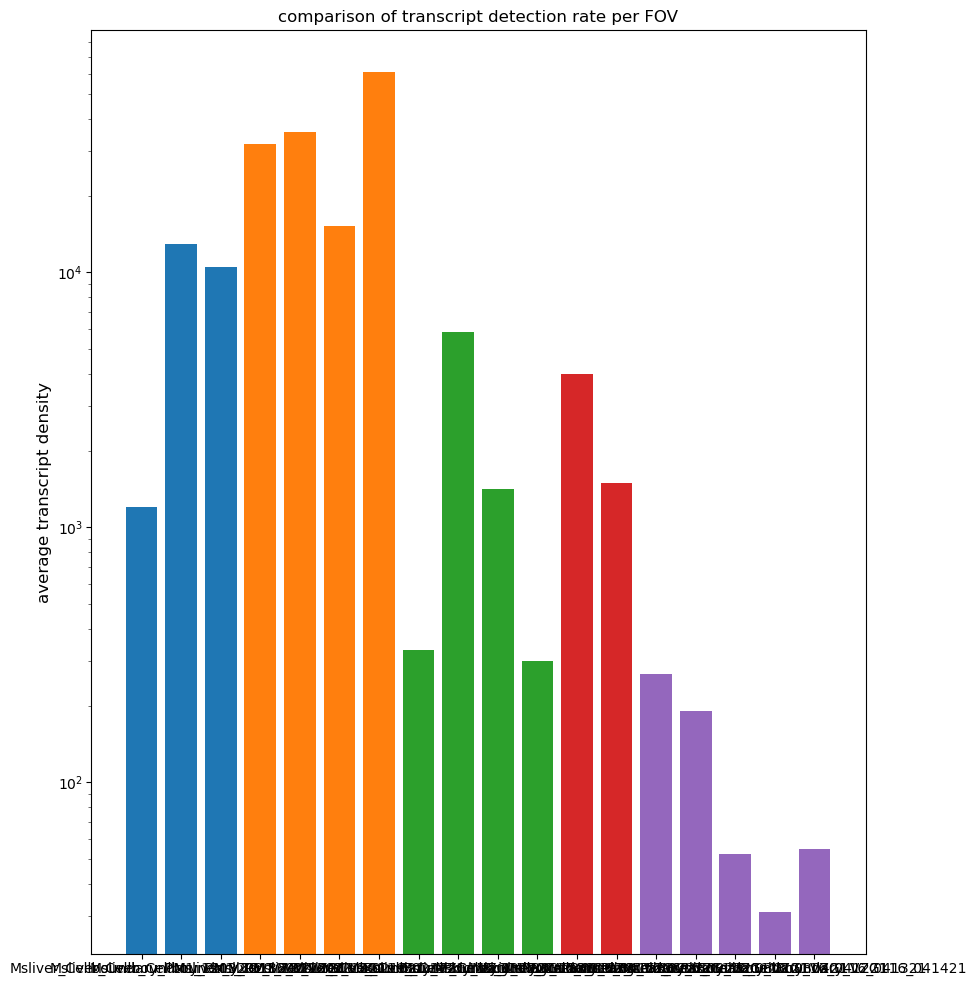

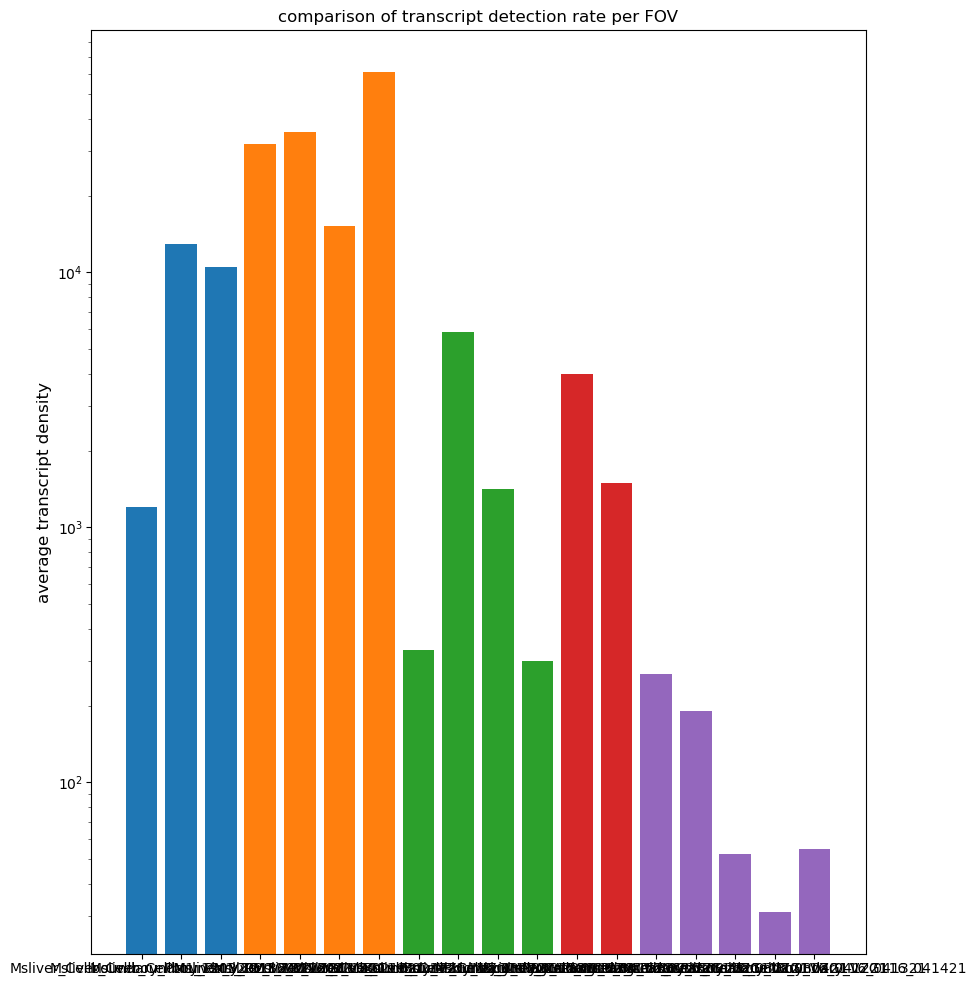

In [118]:
# Plot average barcodes per fov
# For now, just divide total number of detected transcripts by number of fovs

transcriptDensity = {}
for i in range(len(tissues)):
    transcriptDensity[tissues[i]] = [len(detectedTranscripts[tissues[i]][j])
                                     /len(pd.unique(detectedTranscripts[tissues[i]][j]['fov']))
                                         for j in range(len(experimentNames[tissues[i]]))]


# Plot
plt.figure()
for i in range(len(tissues)):
    plt.bar(experimentNames[tissues[i]],transcriptDensity[tissues[i]], color=colors[i])
#plt.xticks(rotation = 45, ha='right')
plt.yscale('log')
plt.ylabel('average transcript density')
#plt.legend(handles=[legend_liver,legend_kidney,legend_pancreas])
plt.title('comparison of transcript detection rate per FOV')

In [100]:
# Calculate same-tissue correlations
corr = {}
for i in range(len(tissues)):
    # Construct column matrix of gene counts in each tissue sample
    tissueCounts = pd.DataFrame([geneCounts[tissues[i]][j]['count'] 
                                 for j in range(len(geneCounts[tissues[i]]))]).transpose()
    corr[tissues[i]] = tissueCounts.corr()

### Plot figure

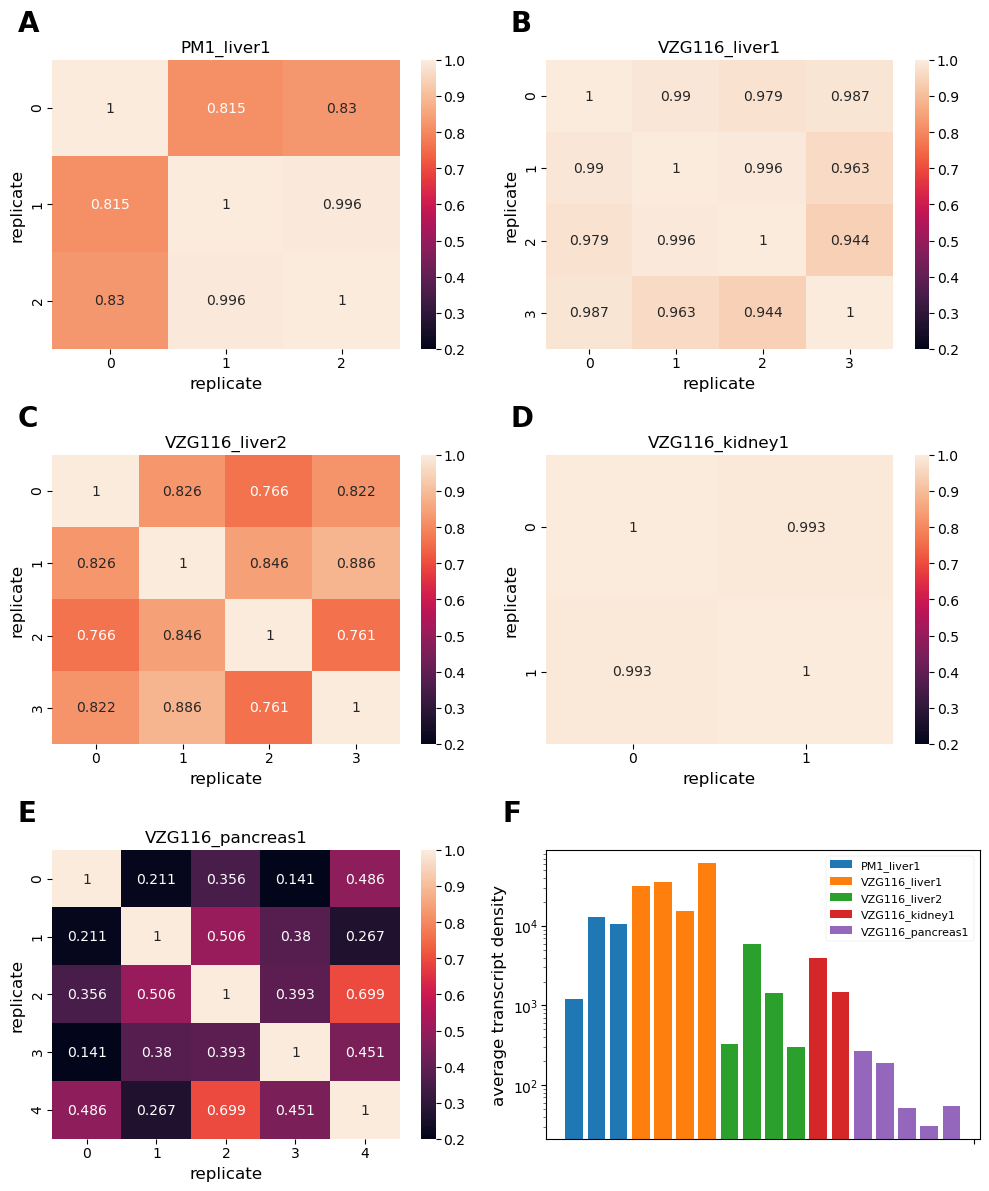

In [127]:
set_plotting_style()

fig, ax = plt.subplots(3,2)

# Plot heatmaps
for i in range(len(tissues)):
    sns.heatmap(corr[tissues[i]], xticklabels = range(len(corr[tissues[i]])), 
               yticklabels = range(len(corr[tissues[i]])), fmt='.3g',
               ax=ax[math.floor(i/2), i%2], annot=True, vmin=0.2, vmax=1)
    ax[math.floor(i/2), i%2].set_title(tissues[i])
    ax[math.floor(i/2), i%2].set_xlabel('replicate')
    ax[math.floor(i/2), i%2].set_ylabel('replicate')
    
# Plot tissue-labeled transcript density
for i in range(len(tissues)):
    ax[2,1].bar(experimentNames[tissues[i]],transcriptDensity[tissues[i]], color=colors[i])
ax[2,1].set_xticks('')
ax[2,1].set_yscale('log')
ax[2,1].set_ylabel('average transcript density')
ax[2,1].legend(tissues, fontsize=8)
#ax[2,1].set_title('comparison of transcript detection rate per FOV')

# Label subpanels
axes = ax.flat
for n, ax in enumerate(axes):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
fig.tight_layout()
fig

In [128]:
# Export figures
fig.savefig('../../figures/SIFig_replicate_correlations.pdf')
fig.savefig('../../figures/SIFig_replicate_correlations.png')